# **1. IMPORT DATASET FROM KAGGLE **

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mindmecha","key":"f3054b0ff021b811d25c0b3dfb44ea07"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d greg115/abstract-art

 99% 292M/296M [00:11<00:00, 29.4MB/s]
100% 296M/296M [00:11<00:00, 28.0MB/s]


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip abstract-art.zip -d "/content/drive/MyDrive/Data_science/abstract-art"

# **IMPORT AND MODIFY DATASET**

In [ ]:
!pip install pillow

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
import seaborn as sns
from PIL import Image, ImageOps, ImageFont, ImageDraw

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
data_path = "/content/drive/MyDrive/Data_science/abstract-art/abstract_art_512"
batch_size = 128
ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    label_mode = None,
    image_size = (64, 64),
    batch_size = batch_size
)

Found 8145 files belonging to 1 classes.


(128, 64, 64, 3)


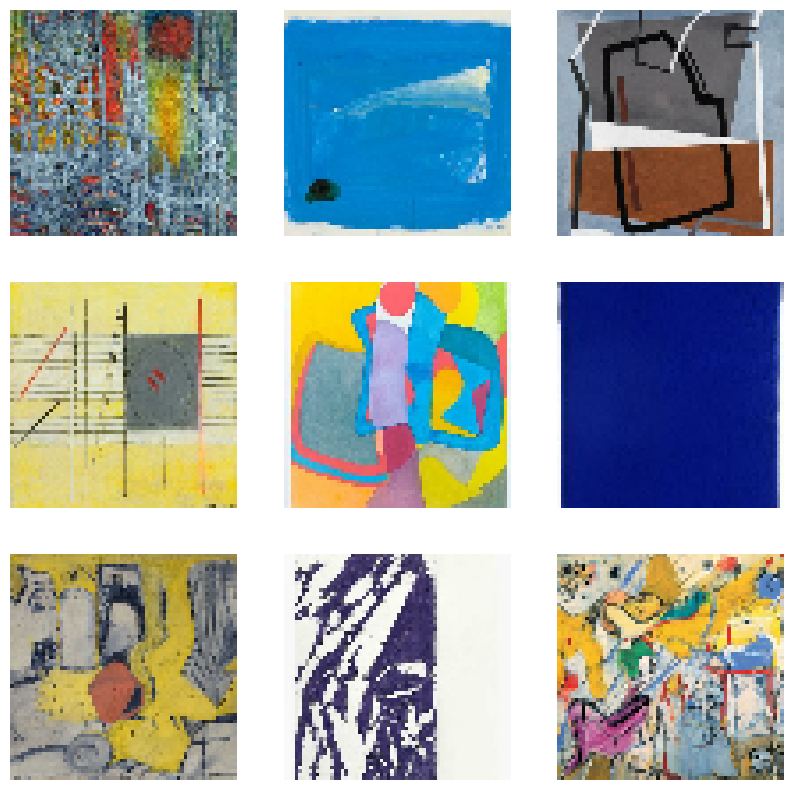

In [5]:
plt.figure(figsize=(10, 10))
for images in ds.take(1):
  print(images.shape)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    plt.axis("off")

In [6]:
for image_batch in ds:
  print(image_batch.shape)
  break

(128, 64, 64, 3)


In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./127.5, offset=-1)
normalized_ds = ds.map(lambda t: normalization_layer(t))

In [8]:
image_batch = next(iter(normalized_ds))

In [ ]:
  # print(np.min(image_batch[0]), np.max(image_batch[0]))

-0.80588233 1.0


In [9]:
AUTOTUNE = tf.data.AUTOTUNE
normalized_ds = normalized_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#  image batch = normalized_data.iter().next()

# ***GENERATOR***

In [10]:
from tensorflow.python.keras.layers.core import Reshape
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, Conv2DTranspose


In [11]:
def build_generator():

  model = Sequential()

  # we will convert it into 4x4x1024
  model.add(Dense(4*4*1024, use_bias=False, input_dim=128))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 1024)))

  assert model.output_shape == (None, 4, 4, 1024)  # Note: None is the batch size

  model.add(Conv2DTranspose(512, (5, 5), strides=2, padding='same', use_bias=False))
  assert model.output_shape == (None, 8, 8, 512)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(256, (5, 5), strides=2, padding='same', use_bias=False))
  assert model.output_shape == (None, 16, 16, 256)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))


  model.add(Conv2DTranspose(128, (5, 5), strides=2, padding='same', use_bias=False))
  assert model.output_shape == (None, 32, 32, 128)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
  assert model.output_shape == (None, 64, 64, 3)
  model.add(tf.keras.layers.Activation("tanh"))

  return model


In [12]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             2097152   
                                                                 
 batch_normalization (Batch  (None, 16384)             65536     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 512)         13107200  
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 8, 8, 512)         2

In [13]:
image_batch[0].shape

TensorShape([64, 64, 3])

In [14]:
img = generator.predict(np.random.randn(4, 128, 1))

1/1 [==============================] - 10s 10s/step


In [15]:
img.shape

(4, 64, 64, 3)

# ***DISCRIMINATOR***

In [16]:
def build_discriminator():

  model = Sequential()

  model.add(Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(64, 64, 3)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.1))

  model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.1))

  model.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.1))

  model.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  return model



In [17]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)        

In [18]:
img.shape

(4, 64, 64, 3)

In [19]:
discriminator.predict(img)

1/1 [==============================] - 0s 487ms/step


array([[0.50184447],
       [0.5018592 ],
       [0.50185084],
       [0.5018491 ]], dtype=float32)

# ***GAN MODEL***

In [62]:
class ArtisticGAN(keras.models.Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)

    self.generator = generator
    self.discriminator = discriminator

    self.batch_size = 128
    self.noise_dim = 128

  def compile(self, g_loss, g_opt, d_loss, d_opt, *args, **kwargs):

    super().compile(*args, **kwargs)

    self.g_loss = g_loss
    self.g_opt = g_opt
    self.d_loss = d_loss
    self.d_opt = d_opt

  def train_step(self, batch):

    real_images = batch
    input_noise = tf.random.normal([self.batch_size, self.noise_dim, 1])
    fake_images = self.generator(input_noise, training=False)

    # train the discriminator

    with tf.GradientTape() as d_tape:

      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)

      yhat_realfake  = tf.concat([yhat_real, yhat_fake], axis=0)

      # we set the output that real is 1 and fake as 0
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      # adding noise to true outputs to cofuse the discriminator

      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    # train generator
    with tf.GradientTape() as g_tape:

      train_input_noise = tf.random.normal([self.batch_size, self.noise_dim, 1])
      generated_imgs = self.generator(train_input_noise, training=True)

      predicted_labels = self.discriminator(generated_imgs, training=False)

      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {"d_loss":total_d_loss, "g_loss":total_g_loss}



In [63]:
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [64]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.0001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

# ***CALLBACK***

In [45]:
from keras.preprocessing.image import array_to_img
import os
from keras.callbacks import Callback

In [46]:
class ModelMonitor(Callback):
  def __init__(self, num_imgs = 3, latent_dims=128):
    self.num_imgs = num_imgs
    self.latent_dims = latent_dims

  def op_epoch_end(self, epoch, logs=None):
    if epoch%5 ==0:
      latent_vector = tf.random.normal((self.num_imgs, latent_dims, 1))
      generated_imgs = self.model.generator(latent_vector)
      generated_images *= 255
      generated_images.numpy()
      for i in range(self.num_img):
              img = array_to_img(generated_images[i])
              img.save('/content/testing_images/'+f'generated_img_{epoch}_{i}.png')


# ***FINALLY TRAIN THE MODEL***

In [65]:
model = ArtisticGAN(generator, discriminator)
model.compile(g_loss=g_loss, g_opt=g_opt, d_loss=d_loss, d_opt=d_opt)

In [66]:
hist = model.fit(normalized_ds, epochs=10, callbacks=[ModelMonitor()])

Epoch 1/10
64/64 [==============================] - 45s 514ms/step - d_loss: 0.4006 - g_loss: 0.4736
Epoch 2/10
64/64 [==============================] - 31s 488ms/step - d_loss: 0.3087 - g_loss: 1.2433
Epoch 3/10
64/64 [==============================] - 32s 495ms/step - d_loss: 0.2775 - g_loss: 0.0520
Epoch 4/10
64/64 [==============================] - 31s 480ms/step - d_loss: 0.2733 - g_loss: 0.0359
Epoch 5/10
64/64 [==============================] - 31s 487ms/step - d_loss: 0.2707 - g_loss: 0.0537
Epoch 6/10
64/64 [==============================] - 31s 487ms/step - d_loss: 0.2703 - g_loss: 0.0574
Epoch 7/10
64/64 [==============================] - 31s 489ms/step - d_loss: 0.2695 - g_loss: 0.0468
Epoch 8/10
64/64 [==============================] - 31s 490ms/step - d_loss: 0.2714 - g_loss: 0.0367
Epoch 9/10
64/64 [==============================] - 31s 484ms/step - d_loss: 0.2754 - g_loss: 0.1428
Epoch 10/10
64/64 [==============================] - 31s 487ms/step - d_loss: 0.3312 - g_lo

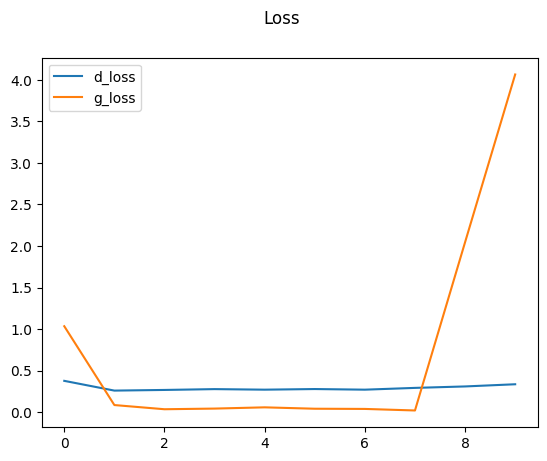

In [67]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [68]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 430ms/step


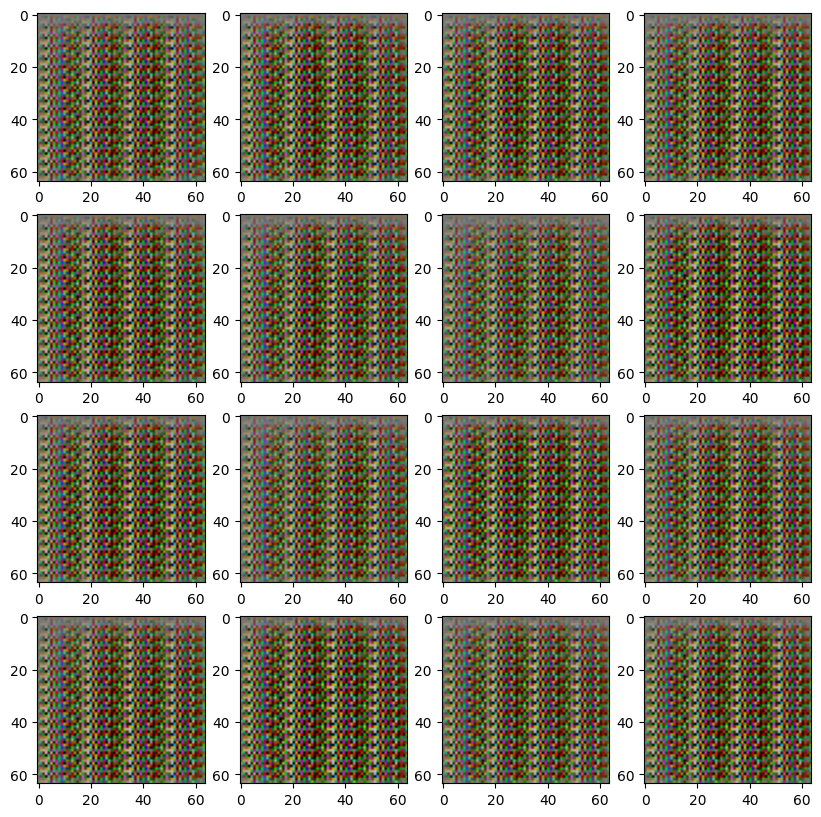

In [69]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

Since only tained for ten epochs it isnt still good enough but it should improve over time as we increase number if epochs to to around 500-100

